# Домашнее задание 3. Алгоритмы кластеризации

Импорт требуемых библиотек:

In [148]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Загружаем данные о пользователях из файла:

In [132]:
data_df = pd.read_csv("hw2_out.csv", sep=",", header=0, index_col="uid")
x = data_df.values

Бросаем игральный тетраэдр:

In [133]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("t.mubarakshin") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'DBSCAN. (параметры - epsilon, min_pts)'


In [134]:
def distance(elem1,elem2):
    res = 0
    p = 2
    #return max(abs(elem-elem2)) #Chebyshev
    return np.power(np.sum((elem1-elem2)**p),1./p) # Minkowski: p=1 - Manhattan, 2 - Euclidean

In [135]:
class dbscan:    
    def __init__(self, minPts,eps):
        self.eps=eps
        self.MinPts=minPts
        return
    
    def neighbours(self,x,elem1):
        res = []
        for i,el in enumerate(x):
            if i!=elem1 and (distance(x[elem1],x[i])<self.eps):
                res.append(i)
        return res
    
    def expand(self,x,elem,elem_neighbours,nvisited,cluster,non_cluster):
        cluster.append(elem)
        non_cluster.remove(elem)
        for nbr in elem_neighbours:
            if nbr in nvisited:
                nvisited.remove(nbr)
                nbr_nbrs = self.neighbours(x,nbr)
                if len(nbr_nbrs) >= self.MinPts:
                    elem_neighbours.extend(nbr_nbrs)
            if nbr in non_cluster:
                non_cluster.remove(nbr)
                cluster.append(nbr)
                
        
    def fit(self, x, y=None):
        return self
    
    def predict(self, x):
        self.x_len = len(x)
        nvisited = set (i for i in xrange(0,self.x_len))
        noise = set()
        clusters = []
        non_cluster = set (i for i in xrange(0,self.x_len))
        while nvisited:
            elem = nvisited.pop()
            elem_nbrs = self.neighbours(x,elem)
            if len(elem_nbrs) < self.MinPts:
                noise.add(elem)
            else:
                cluster = []
                self.expand(x,elem,elem_nbrs,nvisited,cluster,non_cluster)
                clusters.append(cluster)
        
        res = np.zeros(self.x_len)
        for i,cl in enumerate(clusters):
            for elem in cl:
                res[elem] = i
        return res, len(clusters)
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

In [136]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

In [137]:
pred_iris, clusters = dbscan(minPts=1,eps=1.3).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Реализуем критерий качества для модели:

In [9]:
list_dist = []
for i in xrange(0,len(x)):
    for j in xrange(i+1,len(x)):
        list_dist.append(distance(x[i],x[j]))

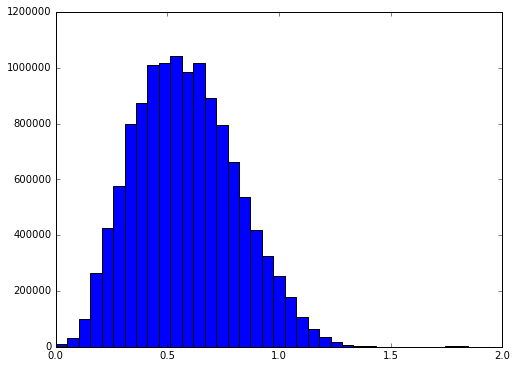

In [10]:
pl.figure(figsize=(8,6))
bins = np.linspace(0,2,40)
pl.hist(list_dist,bins,histtype='bar',color="blue")
pl.show()

In [138]:
matr_dist = ss.distance.pdist(x, 'euclidean')
matr_dist = ss.distance.squareform(matr_dist)

In [139]:
def quality(x, y, clusters, criteria):
    def avg_cl_d(x, y, clusters):
        """
        Average cluster diameter
        """
        if clusters == 0:
            return 0
        cls = []
        for i in xrange(clusters):
            cls.append([])
        for i in xrange(len(x)):
            if int(y[i]) in range(clusters):
                cls[int(y[i])].append(i)

        avg_dist = 0.0
        for cl in cls:
            max_dist = float("-inf")
            for i in xrange(len(cl)):
                for j in xrange(i+1,len(cl)):
                    dxj = distance(x[i],x[j])
                    if dxj > max_dist:
                        max_dist = dxj
            avg_dist += max_dist

        return avg_dist / clusters
    
    def silhouette(x, y, clusters):
        def near_cl_dist(y, i):
            global matr_dist
            means = []
            for clust in range(clusters):
                if clust != y[i]:
                    sum = 0.0
                    total = 0
                    for j in matr_dist[i]:
                        if y[j] == clust:
                            sum += matr_dist[i,j]
                            total += 1
                    means.append(sum / total)
            return np.min(means)
            #return np.min([np.mean([matr_dist[i,y == clust] for clust in range(clusters) if not clust == y[i]])])
        
        def inn_cl_dist(y, i):
            global matr_dist
            in_clust = y == y[i]
            in_clust[i] = False
            if not in_clust.any():
                return 0
            else:
                return np.mean([matr_dist[i, elem] for elem in range(len(y)) if in_clust[elem]])
            
        if clusters <= 1:
            return 1.00
        else:
            A = np.array([inn_cl_dist(y, i) for i in range(len(y))])
            B = np.array([near_cl_dist(y, i) for i in range(len(y))])
            return np.mean((B - A) / np.maximum(A, B))
    
    if criteria == 'avg_cl_d':
        return avg_cl_d(x, y, clusters)
    elif criteria == 'silhouette':
        return silhouette(x, y, clusters)

In [44]:
total = 0.0
for i in x:
    for j in x:
        if (i-j).any() and distance(i,j)<0.138:
            total += 1.0

print total / len(x)

2.10218393108


K =  52 epsilon =  0.084
K =  58 epsilon =  0.09
K =  59 epsilon =  0.096
K =  22 epsilon =  0.102
K =  15 epsilon =  0.108
K =  15 epsilon =  0.114
K =  13 epsilon =  0.12
K =  10 epsilon =  0.126
K =  5 epsilon =  0.132
K =  5 epsilon =  0.138
K =  1 epsilon =  0.144
K =  1 epsilon =  0.15
K =  1 epsilon =  0.156
[52 58 59 22 15 15 13 10  5  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1]
[-0.41431053 -0.41154148 -0.38890227 -0.40749331 -0.32932135 -0.30548518
 -0.29868813 -0.29658479 -0.09531829 -0.0969395   1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


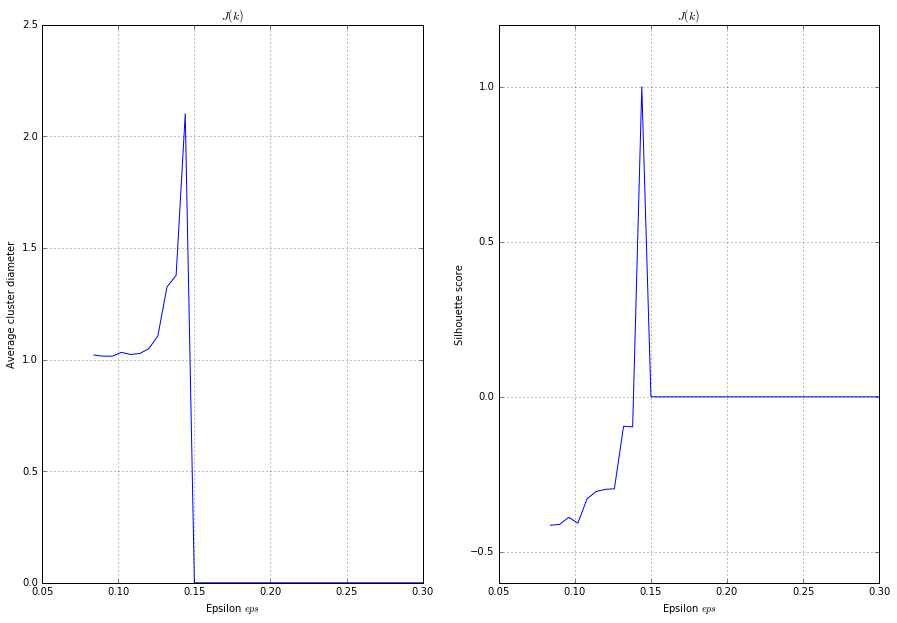

In [147]:
eps = np.linspace(0.084, 0.3, 37)
criteria = np.zeros(len(eps))
criteria2 = np.zeros(len(eps))
clsize = np.ones(len(eps),dtype=int32)

for i,ep in enumerate(eps):
    cls = dbscan(6,ep)
    y, clusters = cls.fit_predict(x)
    print "K = ", clusters, "epsilon = ", ep
    clsize[i] = clusters
    criteria[i] = quality(x, y, clusters, criteria = 'avg_cl_d')
    criteria2[i] = quality(x, y, clusters, criteria = 'silhouette')
    if clsize[i] == 1 and clsize[i-1]>clsize[i]:
        break
        
for i in xrange(0,13):
    print "K = ", clsize[i], "epsilon = ", eps[i]
print clsize
print criteria2
pl.figure(figsize=(15,10))
ax=pl.subplot(1,2,1)
ax.plot(eps,criteria)
pl.title("$J(k)$")
pl.ylabel("Average cluster diameter")
pl.xlabel("Epsilon $eps$")
pl.grid()
ax=pl.subplot(1,2,2)
ax.plot(eps,criteria2)
pl.title("$J(k)$")
pl.ylabel("Silhouette score")
pl.xlabel("Epsilon $eps$")
pl.grid()
pl.show()

Кластеризуем с выбранным $eps$:

In [14]:
cls = dbscan(minPts=6, eps=0.138)
y, clusters = cls.fit_predict(x)
print "Total clusters: ",clusters

Total clusters:  5


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4991
[t-SNE] Computed conditional probabilities for sample 2000 / 4991
[t-SNE] Computed conditional probabilities for sample 3000 / 4991
[t-SNE] Computed conditional probabilities for sample 4000 / 4991
[t-SNE] Computed conditional probabilities for sample 4991 / 4991
[t-SNE] Mean sigma: 0.070371
[t-SNE] Error after 100 iterations with early exaggeration: 1.580380
[t-SNE] Error after 325 iterations: 1.394107


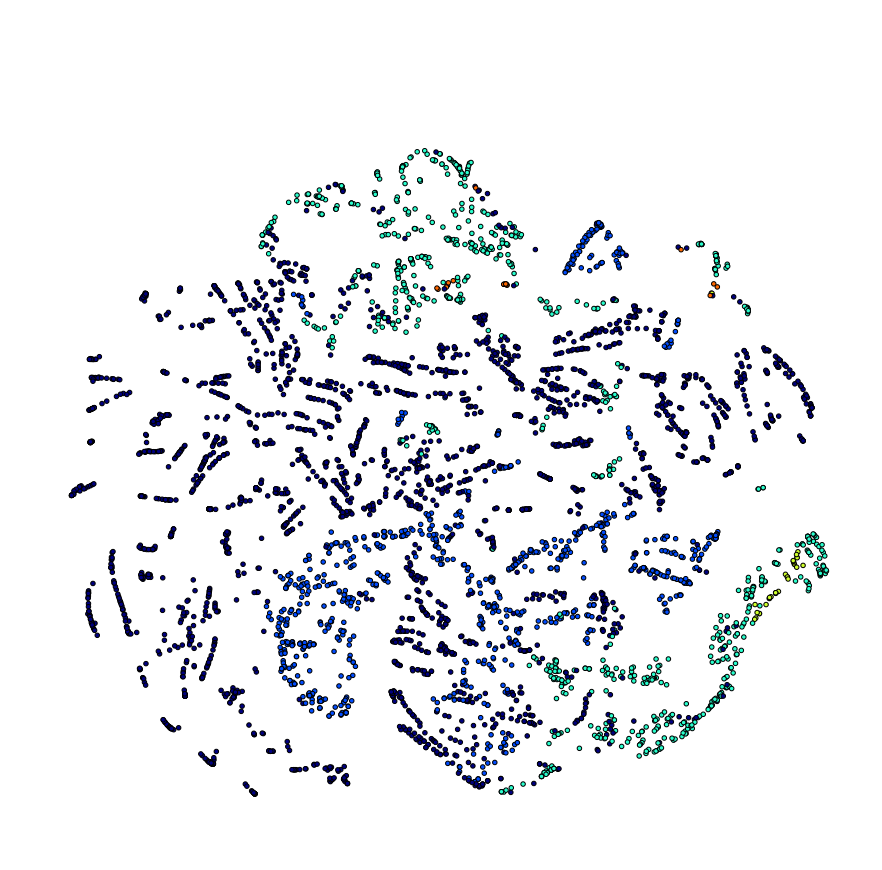

In [16]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

cm = pl.get_cmap('jet')
pl.figure(figsize = (15,15))
pl.scatter(z[:,0], z[:,1], c = map(lambda c: cm(1.0 * c / clusters), y))
pl.axis('off')
pl.show()

In [17]:
for i in data_df:
    print data_df[i].mean()

0.000495675366374
0.00306274987857
0.0240114718817
0.00936819288817
0.00145645296422
0.151901995019
0.728203073224
0.650705019034
0.50370667201


Несмотря на логарифмирование и нормализацию на $[0; 1]$, некоторые значения будут нерепрезентативны на полярном графике (radar), поэтому применим монотонное преобразование $[0; 1] \rightarrow [0; 1]$ - взятие корня 8-й степени:

In [18]:
for i in data_df:
    if data_df[i].mean() < 0.05:
        data_df[i] = np.power(data_df[i], 1./8)
    print data_df[i].mean()

0.263234763653
0.426678817753
0.535950200687
0.414244670367
0.326548376996
0.151901995019
0.728203073224
0.650705019034
0.50370667201


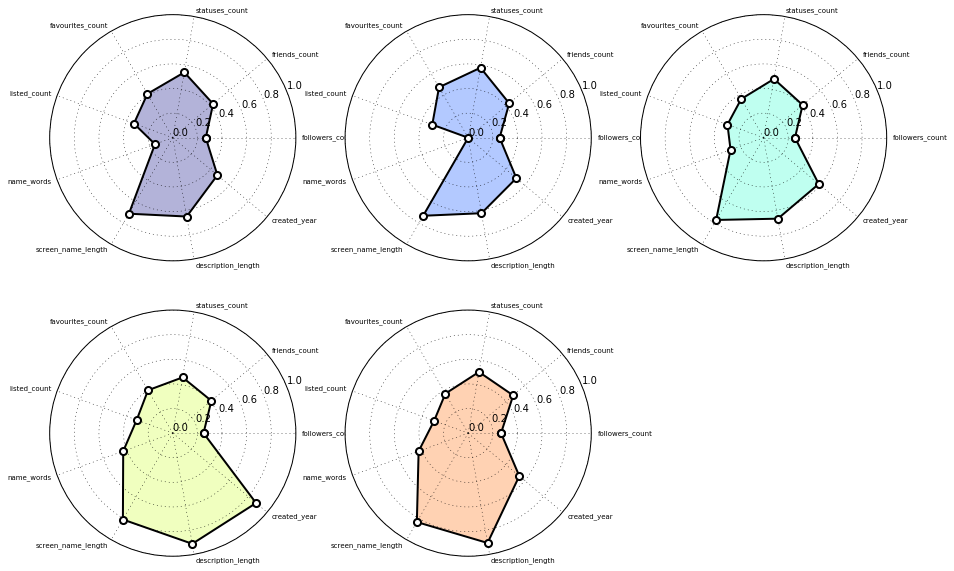

In [22]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

plclusters = np.unique(y)
for j, plcluster in enumerate(clusters):    
    x_c = x[y == plcluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / clusters))

plt.show()